In [3]:
import numpy as np
import tables
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/eframe/dmi/src')
import calibrate as calib
import eventAnalysis as ea
import compton
import sys

In [5]:
# Getting Count Rate 
backfile = '/Users/eframe/Downloads/phantom0deg.h5'
f = tables.open_file( backfile, 'r' )
time = f.root.EventData.read()['timestamp']
duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) # seconds
events = f.root.EventData.read()['timestamp']
edata = f.root.EventData.read().view(np.recarray)
edata.rid = np.arange( len( edata ) )
edata = np.sort(edata, order='timestamp')
i1, i2 = ea.lump_edata(edata, twindow=25)
baseline = len(i1) / duration
print(baseline, time)

1483.3482873620799 [      400472      3804641     10250518 ... 180035007200 180035207695
 180040989911]


In [6]:
mouseA_CI = 724.4042580918143 - 183
mouseB_CI = 384.897707637947 - 183
print(mouseA_CI, mouseB_CI)
917-183

541.4042580918143 201.897707637947


734

In [10]:
# Activity Calculation
t = 5100 # days
A0 = 10 # microcuries
t12 = 30 * 365 # day
lamb = np.log( 2 ) / ( t12 )
A = A0 * np.exp( -lamb * t )
print(A)

7.240928324953128


In [9]:
# Accounting for shielding
muW = 9.776E-02 # cm2/g
tW = 20 / 10 # cm
rhoW = 11 # g/cm3 # Ecomass

muPb = 3.366E+00 # cm2/g
tPb = 1 / 10 # cm
rhoPb = 11.29 # g/cm3

muAl = 1.520E-01 # cm2/g
tAl = 1 / 10 # cm
rhoAl = 2.7 # g/cm3

muPb_1Mev = 7.102E-02
tPb4 = 6.5 / 10 # cm
rhoPb = 11.29 # g/cm3

X1 = muW * rhoW * tW 
X2 = muPb * rhoPb * tPb
X3 = muAl * rhoAl * tAl
X4 = muPb_1Mev * rhoPb * tPb4
X = X1 + X2

np.exp( - X4 )

0.5938192671348166

In [16]:
# Loading Dead Time Files for Cs-137 Rigid Line Source
E_cs, sigma_cs = 662, 2
branch_cs = 0.86
activity_cs = 7.21 # microcuries
inputs_cs = np.array( [ '/Users/eframe/dmi/data/deadtime/cs1.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.9.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.8.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.7.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.6.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.5.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.4.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.3.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.2.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.12.h5',
                   '/Users/eframe/dmi/data/deadtime/cs0.11.h5'] )
R_cs = np.array( [ 1000, 900, 800, 700, 600, 500, 400, 300, 200, 120, 110 ] ) + 16.5 

In [17]:
# Loading Dead Time Files for Co-57 Flexible Source
E_co, sigma_co = 122, 2
branch_co = 0.856
activity_co = 31 # microcuries
inputs_co = np.array( [ '/Users/eframe/dmi/data/deadtime/co1.h5',
                   '/Users/eframe/dmi/data/deadtime/co0.9.h5',
                   '/Users/eframe/dmi/data/deadtime/co0.8.h5',
                   '/Users/eframe/dmi/data/deadtime/co0.7.h5',
                   '/Users/eframe/dmi/data/deadtime/co0.6.h5',
                   '/Users/eframe/dmi/data/deadtime/co0.5.h5',
                   '/Users/eframe/dmi/data/deadtime/co0.4.h5',
                   '/Users/eframe/dmi/data/deadtime/co0.3.h5'] )
R_co = np.array( [ 1000, 910, 800, 700, 600, 500, 400, 290 ] ) + 16.5 

In [3]:
# Getting Background Baseline
backfile = '/Users/eframe/Downloads/background.h5'
f = tables.open_file( backfile, 'r' )
time = f.root.EventData.read()['timestamp']
duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) # seconds
events = f.root.EventData.read()['timestamp']
edata = f.root.EventData.read().view(np.recarray)
edata.rid = np.arange( len( edata ) )
edata = np.sort(edata, order='timestamp')
i1, i2 = ea.lump_edata(edata, twindow=25)
baseline = len(i1) / duration
print(baseline)

183.16037691342981


In [19]:
# Dead Time Calculations for Cs-137 Rigid Line Source
E, sigma = 662, 2
cps_cs, cps_act_cs, invR2_cs = [0], [0], [0]
for i in np.arange( len( inputs_cs ) ):
    f = tables.open_file( inputs_cs[ i ], 'r' )
    time = f.root.EventData.read()['timestamp']
    duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) # seconds
    events = f.root.EventData.read()['timestamp']
    
    # Total Photons Emitted
    photons = activity_cs * 37000 * duration
    egeo = ( 5776 ) / ( 4 * np.pi * R_cs[i] ** 2 + 2 * 5776 ) 
    cps_actual = photons * egeo / duration
    cps_act_cs.append(cps_actual)
    
    # Total Counts Detected
    edata = f.root.EventData.read().view(np.recarray)
    edata.rid = np.arange( len( edata ) )
    edata = np.sort(edata, order='timestamp')
    i1, i2 = ea.lump_edata(edata, twindow=25)
    counts = len(i1) 
    cps_cs.append( counts / duration - baseline )

    invR2_cs.append( 1 / ( R_cs[i] ** 2 * 1 / 1000 ** 2 ) ) 
    print( cps_actual, counts / duration - baseline, inputs_cs[i] )

118.56413390208978 97.24957167864878 /Users/eframe/dmi/data/deadtime/cs1.h5
145.8190726120281 115.66342566381522 /Users/eframe/dmi/data/deadtime/cs0.9.h5
183.6722271051073 140.91153560676113 /Users/eframe/dmi/data/deadtime/cs0.8.h5
238.42123779293317 175.1818612938736 /Users/eframe/dmi/data/deadtime/cs0.7.h5
321.83923683684515 226.6549526495489 /Users/eframe/dmi/data/deadtime/cs0.6.h5
458.05716527285665 312.80530584680446 /Users/eframe/dmi/data/deadtime/cs0.5.h5
703.1191460752176 453.96612581131126 /Users/eframe/dmi/data/deadtime/cs0.4.h5
1212.9406310400198 715.5787627359759 /Users/eframe/dmi/data/deadtime/cs0.3.h5
2565.685292134947 1403.0278516680085 /Users/eframe/dmi/data/deadtime/cs0.2.h5
6271.53115362077 3050.4518154549173 /Users/eframe/dmi/data/deadtime/cs0.12.h5
7246.273269507209 3536.4987494624097 /Users/eframe/dmi/data/deadtime/cs0.11.h5


In [20]:
# Dead Time Calculations for Co-57 Line Source
E, sigma = 122, 2
cps_co, cps_act_co, invR2_co = [0], [0], [0]
for i in np.arange( len( inputs_co ) ):
    f = tables.open_file( inputs_co[ i ], 'r' )
    time = f.root.EventData.read()['timestamp']
    duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) # seconds
    events = f.root.EventData.read()['timestamp']
    
    # Total Photons Emitted
    photons = activity_co * 37000 * duration 
    egeo = ( 5776 ) / ( 4 * np.pi * ( R_co[i] ) ** 2 + 2 * 5776 ) 
    cps_actual = photons * egeo / duration
    cps_act_co.append(cps_actual)
    
    # Total Counts Detected
    edata = f.root.EventData.read().view(np.recarray)
    edata.rid = np.arange( len( edata ) )
    edata = np.sort(edata, order='timestamp')
    i1, i2 = ea.lump_edata(edata, twindow=25)
    counts = len(i1)
    print(counts)
     
    cps_co.append( counts / duration - baseline)
    invR2_co.append( 1 / ( R_co[i] ** 2 * 1 / 1000 ** 2 ) ) 
    print(cps_actual, counts / duration - baseline, inputs_co[i])

161437
509.776442574866 712.3507029942599 /Users/eframe/dmi/data/deadtime/co1.h5
187313
613.5148030251823 856.0707228791483 /Users/eframe/dmi/data/deadtime/co0.9.h5
226885
789.7141526017098 1078.9031314050371 /Users/eframe/dmi/data/deadtime/co0.8.h5
279863
1025.1121181110857 1368.626001191652 /Users/eframe/dmi/data/deadtime/co0.7.h5
353340
1383.7748047076557 1775.986743027559 /Users/eframe/dmi/data/deadtime/co0.6.h5
469081
1969.4552182328098 2430.845302943909 /Users/eframe/dmi/data/deadtime/co0.5.h5
671810
3023.119768145873 3554.274162298359 /Users/eframe/dmi/data/deadtime/co0.4.h5
1198214
5557.642643948091 6472.8826829260015 /Users/eframe/dmi/data/deadtime/co0.3.h5


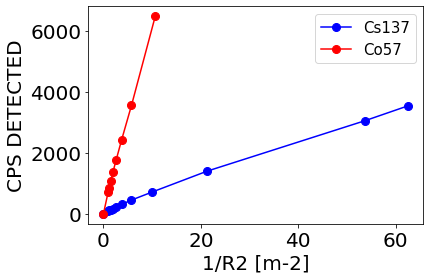

In [21]:
# Plotting CPS VS 1/R2
%matplotlib inline
fig, ax = plt.subplots()
ax.set_xlabel( '1/R2 [m-2]', fontsize=20 )
ax.set_ylabel( 'CPS DETECTED', fontsize=20 )
ax.tick_params( labelsize=20 )
plt.plot( invR2_cs, cps_cs, '.-b', linewidth=1.5, marker = 'o', markersize=8, markerfacecolor='blue', label='Cs137')
plt.plot( invR2_co, cps_co, '.-r', linewidth=1.5, marker = 'o', markersize=8, markerfacecolor='red', label='Co57')
plt.legend(fontsize=15)
plt.show()

In [22]:
m_co = np.polyfit( invR2_co[:2], cps_co[:2], 1 )[0]
m_cs = np.polyfit( invR2_cs[:2], cps_cs[:2], 1 )[0]

cps_ideal_co = np.ceil( np.array( invR2_co ) * m_co )
cps_ideal_cs = np.ceil( np.array( invR2_cs ) * m_cs )
dead_time_co = np.divide( ( cps_ideal_co - cps_co ),  cps_ideal_co, out=np.zeros_like( cps_ideal_co ), where=cps_ideal_co!=0 ) 
dead_time_cs = np.divide( ( cps_ideal_cs - cps_cs ),  cps_ideal_cs, out=np.zeros_like( cps_ideal_cs ), where=cps_ideal_cs!=0 )

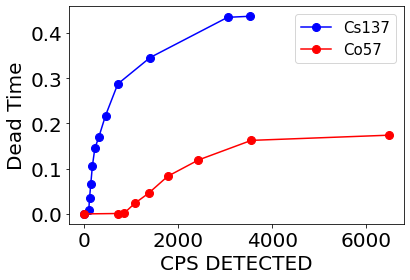

In [23]:
# Plotting CPS VS Dead Time
%matplotlib inline
fig, ax = plt.subplots()
ax.set_xlabel( 'CPS DETECTED', fontsize=20 )
ax.set_ylabel( 'Dead Time', fontsize=20 )
ax.tick_params( labelsize=20 )
plt.plot( cps_cs, dead_time_cs, '.-b', linewidth=1.5, marker = 'o', markersize=8, markerfacecolor='blue', label='Cs137')
plt.plot( cps_co, dead_time_co, '.-r', linewidth=1.5, marker = 'o', markersize=8, markerfacecolor='red', label='Co57')
plt.legend(fontsize=15)
plt.show()